In [1]:
# ===== 依赖（第一次缺库时打开） =====
# !pip -q install pandas numpy pyarrow scikit-learn tqdm

import os, gc, json, re, math, random
from pathlib import Path
from typing import Optional, Dict, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
# ===== 配置区：按需修改 =====
DATA_ROOT = Path("data")   # 你的各类CSV所在根目录

# 先用代表性子集跑通；之后加到全量
FOLDERS = [
    "Benign_Final",
    "DDoS-UDP_Flood", "DDoS-TCP_Flood",
    "DoS-SYN_Flood",
    "Recon-PortScan",
    "SQLInjection",           # 如果抓不到，真实目录可能是 SQL_Injection
    "XSS",
    "Backdoor_Malware",
    "Mirai-udpplain",
    "VulnerabilityScan"
]

TASK_MODE = "multiclass"       # 或 "binary"（Benign vs Attack）
BENIGN_PATTERN = re.compile(r"benign", re.I)

# 读取相关
READ_CHUNK = 200_000           # 每次读20万行，内存稳一些；可 100k~300k 微调
PER_CLASS_LIMIT = None         # 每类最多读取的样本数（None 表示不限制）
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# 需要删除的潜在泄漏/无用列（存在就删）
POSSIBLE_LEAK_COLS = [
    "Flow_ID","FlowID","Flow Id","Flow_IDs",
    "Src_IP","Dst_IP","SourceIP","DestinationIP",
    "Timestamp","Timestamp_Start","Timestamp_End","TimestampStart","TimestampEnd",
    "Label","Attack_type","AttackType","Cat"
]
DROP_PREFIXES = ["Unnamed:"]   # 自动删掉 Unnamed:* 列

# 输出文件
OUT_TRAIN = Path("data/train.parquet")
OUT_VAL   = Path("data/val.parquet")
OUT_TEST  = Path("data/test.parquet")
OUT_META  = Path("data/ciciot2023_split_meta.json")
SAMPLE_1K = Path("data/sample_1k.parquet")   # 可选：保存一个1k小样本

# 切分比例
RATIO_TRAIN, RATIO_VAL, RATIO_TEST = 0.70, 0.15, 0.15
assert abs(RATIO_TRAIN + RATIO_VAL + RATIO_TEST - 1.0) < 1e-6


In [3]:
# ===== 工具函数 =====

def sanitize_chunk(df: pd.DataFrame) -> pd.DataFrame:
    """删除多余列，数值列转 float32，去无限值/缺失。"""
    # 删 Unnamed:* 列
    drop_cols = [c for c in df.columns if any(c.startswith(p) for p in DROP_PREFIXES)]
    df = df.drop(columns=drop_cols, errors="ignore")
    # 删泄漏列
    leak_cols = [c for c in POSSIBLE_LEAK_COLS if c in df.columns]
    if leak_cols:
        df = df.drop(columns=leak_cols, errors="ignore")
    # 数值统一 float32
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols):
        df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
        df[num_cols] = df[num_cols].astype("float32")
        # 简单填充缺失为列中位数（对每个chunk做）
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    # 其余非数值列（除了 label）如果还存在，先丢弃避免 schema 不一致
    # （CICIoT 大多是数值特征，保留 label 即可）
    keep = list(num_cols) + (["label"] if "label" in df.columns else [])
    df = df[keep] if keep else df
    return df

def assign_split_mask(n: int) -> np.ndarray:
    """返回长度为 n 的 {0,1,2} 数组，分别代表 train/val/test。"""
    return np.random.choice(
        np.array([0,1,2], dtype=np.int8),
        size=n,
        p=[RATIO_TRAIN, RATIO_VAL, RATIO_TEST]
    )

def ensure_schema_and_reindex(df: pd.DataFrame, all_cols: Optional[list]) -> Tuple[pd.DataFrame, list]:
    """保证每个chunk列顺序一致；首次出现时记录列名，之后按该顺序补列。"""
    if all_cols is None:
        all_cols = [c for c in df.columns if c != "label"] + (["label"] if "label" in df.columns else [])
        return df[all_cols], all_cols
    missing = [c for c in all_cols if c not in df.columns]
    if missing:
        for m in missing:
            df[m] = np.nan
    # 可能有多余列（意外），也按 all_cols 选择
    df = df[all_cols]
    return df, all_cols

class SplitWriters:
    """封装三个 ParquetWriter，支持增量写入。"""
    def __init__(self, out_train: Path, out_val: Path, out_test: Path):
        self.paths = [out_train, out_val, out_test]
        self.writers = [None, None, None]
        self.schema = None
        self.counts = [0, 0, 0]   # 行数计数
        # 如果目标文件已存在，先删
        for p in self.paths:
            if p.exists(): p.unlink()

    def write(self, df: pd.DataFrame, split_id: int):
        # 转 Arrow Table
        table = pa.Table.from_pandas(df, preserve_index=False)
        if self.schema is None:
            self.schema = table.schema
        # 首次创建 writer
        if self.writers[split_id] is None:
            self.writers[split_id] = pq.ParquetWriter(self.paths[split_id], self.schema, compression="zstd")
        self.writers[split_id].write_table(table)
        self.counts[split_id] += df.shape[0]

    def close(self):
        for w in self.writers:
            if w is not None:
                w.close()

def label_from_folder(folder_name: str) -> str:
    if TASK_MODE == "binary":
        return "Benign" if BENIGN_PATTERN.search(folder_name) else "Attack"
    return folder_name


In [4]:
# ===== 主流程：逐类、逐块处理，并直接写入 train/val/test.parquet =====
all_feature_cols = None
writers = SplitWriters(OUT_TRAIN, OUT_VAL, OUT_TEST)
classes_seen = []

for cname in FOLDERS:
    fdir = DATA_ROOT / cname
    if not fdir.exists():
        print(f"[skip] {cname} 不存在")
        continue

    print(f"==> Processing class: {cname}")
    classes_seen.append(label_from_folder(cname))

    total_got = 0
    csv_files = sorted(list(fdir.glob("*.csv")))
    if not csv_files:
        print(f"warn: {cname} has no csv")
        continue

    for csv in csv_files:
        try:
            for chunk in pd.read_csv(csv, chunksize=READ_CHUNK, low_memory=False):
                # 加标签
                chunk["label"] = label_from_folder(cname)
                # 清洗/统一类型
                chunk = sanitize_chunk(chunk)
                # 与全局列对齐
                chunk, all_feature_cols = ensure_schema_and_reindex(chunk, all_feature_cols)

                # 分配切分（类内按比例）
                mask = assign_split_mask(len(chunk))
                # 分别写入三个文件
                for sid in (0,1,2):  # 0-train,1-val,2-test
                    part = chunk[mask == sid]
                    if len(part):
                        writers.write(part, sid)

                total_got += len(chunk)
                # 达到每类上限则提前停止
                if PER_CLASS_LIMIT is not None and total_got >= PER_CLASS_LIMIT:
                    break
            if PER_CLASS_LIMIT is not None and total_got >= PER_CLASS_LIMIT:
                break
        except Exception as e:
            print("!! read fail:", csv, e)
            continue

    print(f"{cname}: written ~{total_got:,} rows")

writers.close()
print("写入完成：")
print(" train rows =", writers.counts[0])
print("   val rows =", writers.counts[1])
print("  test rows =", writers.counts[2])
print(" n_features (w/o label) =", (len(all_feature_cols)-1) if all_feature_cols else None)


==> Processing class: Benign_Final
Benign_Final: written ~1,098,191 rows
==> Processing class: DDoS-UDP_Flood
DDoS-UDP_Flood: written ~5,412,231 rows
==> Processing class: DDoS-TCP_Flood
DDoS-TCP_Flood: written ~4,497,649 rows
==> Processing class: DoS-SYN_Flood
DoS-SYN_Flood: written ~2,028,836 rows
==> Processing class: Recon-PortScan
Recon-PortScan: written ~82,284 rows
[skip] SQLInjection 不存在
==> Processing class: XSS
XSS: written ~3,846 rows
==> Processing class: Backdoor_Malware
Backdoor_Malware: written ~3,218 rows
==> Processing class: Mirai-udpplain
Mirai-udpplain: written ~890,574 rows
==> Processing class: VulnerabilityScan
VulnerabilityScan: written ~373,351 rows
写入完成：
 train rows = 10073978
   val rows = 2158123
  test rows = 2158079
 n_features (w/o label) = 39


In [5]:
# ===== 保存元数据 & 快速抽样 =====
meta = dict(
    task_mode=TASK_MODE,
    class_names=sorted(set(classes_seen)) if TASK_MODE=="multiclass" else ["Attack","Benign"],
    seed=SEED,
    folders=FOLDERS,
    ratios=dict(train=RATIO_TRAIN, val=RATIO_VAL, test=RATIO_TEST),
    shapes=dict(train=writers.counts[0], val=writers.counts[1], test=writers.counts[2]),
    files=dict(train=str(OUT_TRAIN), val=str(OUT_VAL), test=str(OUT_TEST)),
)
with open(OUT_META, "w") as f:
    json.dump(meta, f, indent=2)
print("已保存元数据：", OUT_META)

# 保存一个1k的小样本方便调试（从train里取）
try:
    df_head = pd.read_parquet(OUT_TRAIN, engine="pyarrow", columns=None, filters=None).sample(
        n=min(1000, writers.counts[0]), random_state=SEED
    )
    df_head.to_parquet(SAMPLE_1K)
    print("已保存小样本：", SAMPLE_1K)
except Exception as e:
    print("保存小样本失败：", e)


已保存元数据： data/ciciot2023_split_meta.json
已保存小样本： data/sample_1k.parquet


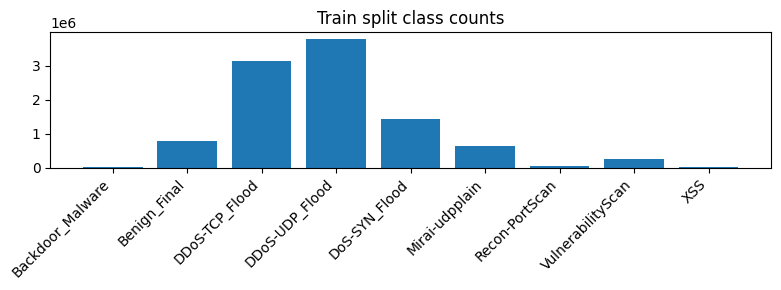

完成。接下来在 100/110/120/130 里直接读取：
 - data/train.parquet, data/val.parquet, data/test.parquet
 - data/ciciot2023_split_meta.json (拿到 class_names 和 task_mode)


In [6]:
# ===== 简单可视化：训练集各类样本数（若是二分类，就显示2类） =====
import matplotlib.pyplot as plt

# 只读少量（或全部）train 统计标签分布；这里直接全部读train的'label'列统计
train_labels = pd.read_parquet(OUT_TRAIN, columns=["label"])
counts = train_labels["label"].value_counts().sort_index()

plt.figure(figsize=(8,3))
plt.bar(range(len(counts)), counts.values)
plt.xticks(range(len(counts)), counts.index, rotation=45, ha='right')
plt.title("Train split class counts")
plt.tight_layout(); plt.show()

print("完成。接下来在 100/110/120/130 里直接读取：")
print(" - data/train.parquet, data/val.parquet, data/test.parquet")
print(" - data/ciciot2023_split_meta.json (拿到 class_names 和 task_mode)")


In [7]:
# 只需在 001 跑一次
from google.colab import drive
drive.mount('/content/drive')

import shutil, os
SRC = "/content/data"
DST = "/content/drive/MyDrive/INCS870/data"
os.makedirs(DST, exist_ok=True)

for fn in ["train.parquet","val.parquet","test.parquet","ciciot2023_split_meta.json"]:
    if os.path.exists(f"{SRC}/{fn}"):
        shutil.copy(f"{SRC}/{fn}", f"{DST}/{fn}")
        print("copied:", fn)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
copied: train.parquet
copied: val.parquet
copied: test.parquet
copied: ciciot2023_split_meta.json
